<a href="https://colab.research.google.com/github/Arush0113/ArushTensorflowRepo/blob/main/Coding_Tutorial_week_3_tut5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [3]:
# Save the input and target variables
print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis = 0))/ targets.std()
targets


array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)


(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [78]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def get_model():
  model = Sequential([
                    Dense(128, activation = 'relu', input_shape = (train_data.shape[1],)),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1)
  ])
  return model



In [84]:
# Print the model summary
model = get_model()

model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_64 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_66 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_67 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_68 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                

In [85]:
# Compile the model
model.compile(optimizer= 'adam', loss= 'mse', metrics= ['mae'])


In [86]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs = 100, verbose = False, batch_size= 64, validation_split = 0.15)


In [87]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose = 2)


2/2 - 0s - loss: 0.8853 - mae: 0.7124


[0.8852910399436951, 0.7123876214027405]

#### Plot the learning curves

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

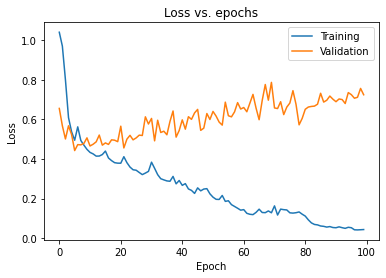

In [89]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [90]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [91]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", kernel_regularizer= regularizers.l2(wd), input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dense(1)
    ])
    return model

In [92]:
# Re-build the model with weight decay and dropout layers
regularised_model = get_regularised_model(1e-5, 0.3)


In [93]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])


In [94]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs = 100, batch_size= 64, validation_split=0.15, verbose=False)


In [95]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose = 2)


2/2 - 0s - loss: 0.8879 - mae: 0.7465


[0.8879028558731079, 0.7465091943740845]

#### Plot the learning curves

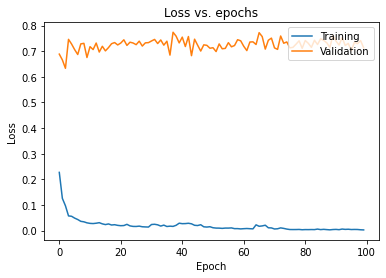

In [96]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [97]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):

  def on_train_begin(self, logs = None):
    print('Starting training....')

  def on_epoch_begin(self, epoch, logs = None):
    print(f"Starting epoch {epoch}")

  def on_train_batch_begin(self, batch, logs = None):
    print(f"Starting batch {batch}")
  
  def on_train_batch_end(self, batch, logs = None):
    print(f"Finished batch {batch}")
  
  def on_epoch_end(self, epoch, logs = None):
    print(f"Finished epoch {epoch}")

  def on_train_end(self, logs = None):
    print('Finished Training!')


In [98]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [99]:
# Compile the model
model.compile(optimizer = "adam", loss = "mse")


#### Train the model with the callback

In [100]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs = 3, batch_size = 128, verbose = False, callbacks = [TrainingCallback()])

Starting training....
Starting epoch 0
Starting batch 0
Finished batch 0
Starting batch 1
Finished batch 1
Starting batch 2
Finished batch 2
Starting batch 3
Finished batch 3
Finished epoch 0
Starting epoch 1
Starting batch 0
Finished batch 0
Starting batch 1
Finished batch 1
Starting batch 2
Finished batch 2
Starting batch 3
Finished batch 3
Finished epoch 1
Starting epoch 2
Starting batch 0
Finished batch 0
Starting batch 1
Finished batch 1
Starting batch 2
Finished batch 2
Starting batch 3
Finished batch 3
Finished epoch 2
Finished Training!


In [101]:
# Evaluate the model
class TestingCallback(Callback):
  def on_test_begin(self, logs = None):
    print("Starting testing....")

  def on_test_batch_begin(self, batch, logs = None):
    print(f"Testing: Starting Batch {batch}")

  def on_test_batch_end(self, batch, logs = None):
    print(f"Testing: Finished Batch {batch}")

  def on_test_end(self, logs = None):
    print("Finished Testing!")

model.evaluate(test_data, test_targets, verbose = False)

0.9887192845344543

In [102]:
# Make predictions with the model

class PredictionCallback(Callback):
  def on_predict_begin(self, logs = None):
    print("Starting prediction....")

  def on_predict_batch_begin(self, batch, logs = None):
    print(f"Prediction: Starting Batch {batch}")

  def on_predict_batch_end(self, batch, logs = None):
    print(f"Prediction: Finished Batch {batch}")

  def on_predict_end(self, logs = None):
    print("Finished prediction!")

model.predict(test_data, verbose= False, callbacks= [PredictionCallback()])

Starting prediction....
Prediction: Starting Batch 0
Prediction: Finished Batch 0
Prediction: Starting Batch 1
Prediction: Finished Batch 1
Finished prediction!


array([[-0.06255727],
       [-0.01260474],
       [ 0.11786417],
       [-0.00376952],
       [-0.01063718],
       [-0.05546352],
       [ 0.02859299],
       [ 0.08169273],
       [-0.04125163],
       [ 0.01564615],
       [-0.0181624 ],
       [-0.03906571],
       [-0.00481038],
       [ 0.01488171],
       [ 0.07522446],
       [ 0.05731096],
       [ 0.07860776],
       [ 0.07689581],
       [-0.05387317],
       [ 0.07914215],
       [-0.05591302],
       [-0.02089093],
       [ 0.01089357],
       [ 0.06593467],
       [-0.03124452],
       [ 0.09889002],
       [-0.01476975],
       [-0.06036148],
       [ 0.07311678],
       [ 0.09772652],
       [ 0.09346818],
       [ 0.06253087],
       [ 0.07779832],
       [-0.05937584],
       [-0.02822529],
       [-0.0256865 ],
       [ 0.06901043],
       [ 0.07892044],
       [-0.05523967],
       [ 0.02697918],
       [-0.04362435],
       [-0.05464616],
       [ 0.09467123],
       [ 0.06555521],
       [ 0.0724759 ]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [103]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer = "adam", loss = "mse")
unreg_history = unregularised_model.fit(train_data, train_targets, epochs = 100, validation_split = 0.15,
                                        batch_size = 64, verbose = False, callbacks = [tf.keras.callbacks.EarlyStopping()])


In [104]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose = 2)

2/2 - 0s - loss: 0.5801


0.580068826675415

In [105]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer="adam", loss = "mse")
reg_history = regularised_model.fit(train_data, train_targets, epochs = 100, validation_split = 0.15,
                                    batch_size = 64, verbose = False, callbacks = [tf.keras.callbacks.EarlyStopping()])


In [ ]:
# Evaluate the model on the test set



#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()